In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import time

import os
import shutil

In [2]:
in_dir = '/kaggle/input/gan-getting-started'
out_dir = '/kaggle/working'

monet_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/monet_tfrec')
monet_jpg_names = tf.io.gfile.listdir(f'{in_dir}/monet_jpg')
photo_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/photo_tfrec')
photo_jpg_names = tf.io.gfile.listdir(f'{in_dir}/photo_jpg')

print(f'There are {len(monet_tfrec_names)} Monet TFRecord collections')
print(f'There are {len(monet_jpg_names)} Monet jpgs in total')
print(f'There are {len(photo_tfrec_names)} photo TFRecord collections')
print(f'There are {len(photo_jpg_names):,} photo jpgs in total')
print()
print(f'Sample of what the TFRecord files look like: {monet_tfrec_names}')

There are 5 Monet TFRecord collections
There are 300 Monet jpgs in total
There are 20 photo TFRecord collections
There are 7,038 photo jpgs in total

Sample of what the TFRecord files look like: ['monet12-60.tfrec', 'monet16-60.tfrec', 'monet08-60.tfrec', 'monet04-60.tfrec', 'monet00-60.tfrec']


In [3]:
ex = tf.train.Example()
ex.ParseFromString(
    next(iter(tf.data.TFRecordDataset(f'{in_dir}/monet_tfrec/{monet_tfrec_names[0]}').take(1))).numpy()
)
[k for k in ex.features.feature.keys()]

['target', 'image_name', 'image']

In [4]:
tfrecs_monet = tf.data.TFRecordDataset([f'{in_dir}/monet_tfrec/{f}' for f in monet_tfrec_names])
tfrecs_photo = tf.data.TFRecordDataset([f'{in_dir}/photo_tfrec/{f}' for f in photo_tfrec_names])
    
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string)
    , 'image': tf.io.FixedLenFeature([], tf.string)
    , 'target': tf.io.FixedLenFeature([], tf.string)
    
}

def parse_image(record):
    img = tf.io.parse_single_example(record, feature_description)['image']
    img = tf.io.decode_image(
        img
        , channels=3
    )
    img = tf.cast(img, tf.float32) / 255.0

    return img

parsed_images_monet = tfrecs_monet.map(parse_image)
parsed_images_photo = tfrecs_photo.map(parse_image)

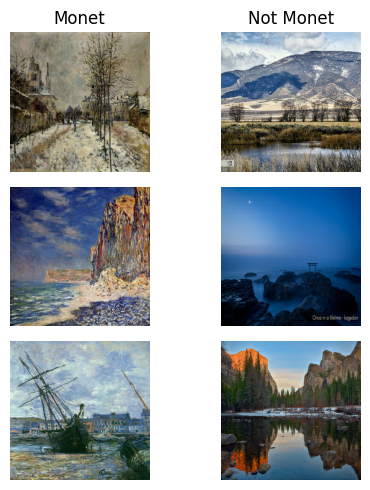

In [5]:
fig, axes = plt.subplots(
    3
    , 2
    , figsize=(5,5)
)

iter_monet = iter(parsed_images_monet)
iter_photo = iter(parsed_images_photo)

axes[0,0].imshow(next(iter_monet))
axes[0,1].imshow(next(iter_photo))
axes[1,0].imshow(next(iter_monet))
axes[1,1].imshow(next(iter_photo))
axes[2,0].imshow(next(iter_monet))
axes[2,1].imshow(next(iter_photo))

axes[0,0].set_title('Monet')
axes[0,1].set_title('Not Monet')

for ax in axes.ravel():
    ax.set_axis_off()

fig.tight_layout()

In [6]:
def encode(n_filters, filter_size):    
    return models.Sequential([
        layers.Conv2D(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
    ])

def decode(n_filters, filter_size):
    return models.Sequential([
        layers.Conv2DTranspose(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        , layers.Dropout(0.5)
        , layers.ReLU()
    ])

In [7]:
print(encode(3, 4)(tf.expand_dims(next(iter_monet), 0)).shape)
print((decode(3, 4)(encode(3,4)(tf.expand_dims(next(iter_monet), 0)))).shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


In [8]:
def construct_generator():
    encoding_stack = [
        encode(64, 4)    
        , encode(128, 4) 
        , encode(256, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
    ]

    decoding_stack = [
        decode(512, 4)   
        , decode(512, 4) 
        , decode(512, 4) 
        , decode(512, 4) 
        , decode(256, 4) 
        , decode(128, 4) 
        , decode(64, 4)  
    ]

    final_decoding_layer = layers.Conv2DTranspose(
        3
        , 4
        , strides=2
        , padding='same'
        , activation='tanh'
    )                    

    inputs = layers.Input((256, 256, 3))

    translated_images = inputs

    
    skips = []
    for endecoder in encoding_stack:
        translated_images = endecoder(translated_images)
        skips.append(translated_images)

    
    skips = reversed(skips[:-1])

    
    for decoder, skip in zip(decoding_stack, skips):
        translated_images = decoder(translated_images)
        translated_images = layers.Concatenate()([translated_images, skip])

    
    translated_images = final_decoding_layer(translated_images)

    return tf.keras.Model(inputs=inputs, outputs=translated_images) 

In [9]:
# visualize the generator

generator = construct_generator()
generator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 128, 128,  │      3,200 │ input_layer_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 64, 64,    │    131,328 │ sequential_3[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 32, 32,    │    524,800 │ sequential_4[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 16, 16,    │  2,098,176 │ sequential_5[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 8, 8, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 4, 4, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 2, 2, 512) │  4,195,328 │ sequential_8[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 1, 1, 512) │  4,195,328 │ sequential_9[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 2, 2, 512) │  4,194,304 │ sequential_10[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_11[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 4, 4, 512) │  8,388,608 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_12[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 8, 8, 512) │  8,388,608 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_13[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 16, 16,    │  8,388,608 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_14[0]

 Total params: 54,410,115 (207.56 MB)

 Trainable params: 54,410,115 (207.56 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
generator_monet_to_photo = construct_generator()
generator_photo_to_monet = construct_generator()

In [11]:
def construct_discriminator():
    inputs = layers.Input((256, 256, 3))

    out = models.Sequential([
        layers.Input((256, 256, 3))
        , encode(64, 4)          
        , encode(128, 4)         
        , encode(256, 4)         
        , layers.ZeroPadding2D() 
        , layers.Conv2D(
            512
            , 4
            , strides=1
            , use_bias=False
        )                        
        
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
        , layers.ZeroPadding2D() 
        , layers.Conv2D(
            1
            , 4
            , strides=1
        )                        
    
    ])(inputs) 

    return tf.keras.Model(inputs=inputs, outputs=out)

In [12]:
discriminator = construct_discriminator()
discriminator.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_51 (Sequential)      │ (None, 30, 30, 1)      │     2,765,697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,697 (10.55 MB)

 Trainable params: 2,765,697 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
discriminator_monet = construct_discriminator()
discriminator_photo = construct_discriminator()

In [14]:
# Lambda controls the magnitude of the effect of the cycle consistency loss.
# A higher lambda means cycle consistency loss plays a larger role in relation
# to adversarial loss. A lower lambda flips that importance.
lambda_param = 10

def generator_loss(generated_image):
    return losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(generated_image)
        , generated_image
    )

def discriminator_loss(real_image, generated_image):
    loss_real = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_image), real_image)
    loss_generated = losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_image), generated_image)
    return (loss_real + loss_generated) * 0.5

def cycle_loss(real_image, cycled_image):
    return lambda_param * tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float32) - cycled_image))

def identity_loss(real_image, generated_image):
    return lambda_param * 0.5 * tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float32) - generated_image))

In [15]:
ds_monet = parsed_images_monet.batch(1)
ds_photo = parsed_images_photo.batch(1)

In [16]:
generator_monet_to_photo = construct_generator()
generator_photo_to_monet = construct_generator()

discriminator_monet = construct_discriminator()
discriminator_photo = construct_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 5 # my computer is slow :(

for epoch in range(n_epochs):
    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        n += 1
    print("epoch: ", epoch, "completed")

epoch:  0 completed
epoch:  1 completed
epoch:  2 completed
epoch:  3 completed
epoch:  4 completed


In [17]:
def show_images(model, test_input):
    pred = model(test_input)
    
    fig, axes = plt.subplots(
        1
        , 2
        , figsize=(15,15)
    )

    axes[0].imshow(test_input[0].numpy().squeeze())
    axes[1].imshow(pred[0].numpy().squeeze())

    axes[0].set_title('Real Image', fontsize=24)
    axes[1].set_title('Generated Image', fontsize=24)

    # Turn axis labels and grids off
    for ax in axes.ravel():
        ax.set_axis_off()

    fig.tight_layout()
    plt.show()

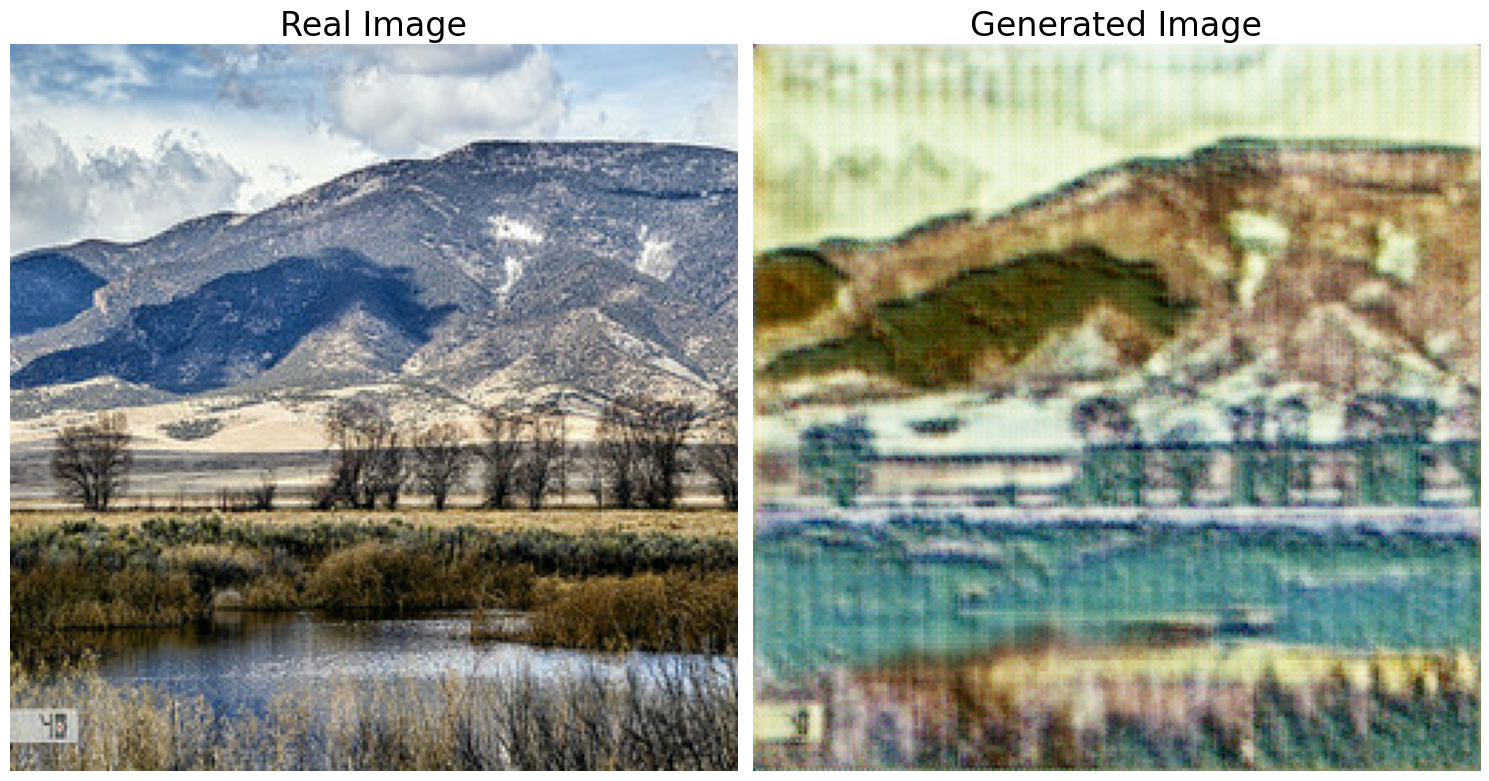

In [18]:
sample_photo = [image for image in ds_photo.take(1)]
show_images(generator_photo_to_monet, sample_photo)


In [19]:
if os.path.exists(f'{out_dir}/imgs'):
    shutil.rmtree(f'{out_dir}/imgs')
os.makedirs(f'{out_dir}/imgs')

n=1
for img in ds_photo:
    pred = (generator_photo_to_monet(img, training=False)[0].numpy().squeeze() * 255).astype(np.uint8)
    tf.keras.utils.save_img(f'{out_dir}/imgs/{n}.jpg', pred)
    n += 1
    
shutil.make_archive(f'{out_dir}/images', 'zip', f'{out_dir}/imgs')
shutil.rmtree(f'{out_dir}/imgs')